In [1]:
import pylearn2.utils
import pylearn2.config
import theano
import neukrill_net.dense_dataset
import neukrill_net.utils
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import holoviews as hl
%load_ext holoviews.ipython
import sklearn.metrics

Using gpu device 0: Tesla K40c
:0: FutureWarning: IPython widgets are experimental and may change in the future.


Welcome to the HoloViews IPython extension! (http://ioam.github.io/holoviews/)
Available magics: %compositor, %opts, %params, %view, %%labels, %%opts, %%view


In [2]:
cd ..

/afs/inf.ed.ac.uk/user/s08/s0805516/repos/neukrill-net-work


Building the model
----------------

This time we want to use a CompositeSpace again, but one of the inputs will just be a vector of pre-computed OpenCV features calculated straight from the raw images.

In [125]:
import pylearn2.space

In [126]:
final_shape = (48,48)
vector_size = 100

In [127]:
input_space = pylearn2.space.CompositeSpace([
    pylearn2.space.Conv2DSpace(shape=final_shape,num_channels=1,axes=['b',0,1,'c']),
    pylearn2.space.VectorSpace(vector_size)
    ])

Composite Layers
--------------

Up until we reach the fully connected layers we want to have a convolutional pipeline and a spacetransformer pipeline that just passes the vector inputs to the MLP layer. To do this, we have to define two of these pipelines inside a CompositeLayer.

In [128]:
import pylearn2.models.mlp
import pylearn2.blocks

First, we have to instantiate the above layers as their own MLP objects. Originally, I thought these should have an `input_source` to specify the inputs they take, turns out __nested MLPs do not have input or target sources__. Instantiating each:

In [129]:
convlayer = pylearn2.models.mlp.MLP(
    layer_name="convlayer",
    batch_size=128,
    layers=[pylearn2.models.mlp.ConvRectifiedLinear(
            layer_name='h1',
            output_channels=48,
            irange=0.025,
            init_bias=0,
            kernel_shape=[8,8],
            pool_shape=[2,2],
            pool_stride=[2,2],
            max_kernel_norm=1.9365
            ),
            pylearn2.models.mlp.ConvRectifiedLinear(
            layer_name='h2',
            output_channels=96,
            irange=0.025,
            init_bias=0,
            kernel_shape=[5,5],
            pool_shape=[2,2],
            pool_stride=[2,2],
            max_kernel_norm=1.9365
            ),
            pylearn2.models.mlp.ConvRectifiedLinear(
            layer_name='h3',
            output_channels=128,
            irange=0.025,
            init_bias=0,
            kernel_shape=[3,3],
            pool_shape=[2,2],
            pool_stride=[2,2],
            max_kernel_norm=1.9365
            ),
            pylearn2.models.mlp.ConvRectifiedLinear(
            layer_name='h4',
            output_channels=128,
            irange=0.025,
            init_bias=0,
            kernel_shape=[3,3],
            pool_shape=[2,2],
            pool_stride=[2,2],
            max_kernel_norm=1.9365
            )
        ]
    )

Can't figure out what the layer is called that just acts as a dummy so putting in a single MLP layer in the mean time. Could cause us problems.

In [130]:
passthrough = pylearn2.models.mlp.MLP(
    layer_name="passthrough",
    batch_size=128,
    layers=[pylearn2.models.mlp.RectifiedLinear(
                dim=256,
                max_col_norm=1.9,
                layer_name='h1p5',
                istdev=0.05,
                W_lr_scale=0.25,
                b_lr_scale=0.25)])

Then we can initialise our CompositeLayer with these two stacks of convolutional layers. Have to define dictionary mapping which of the inputs in the composite space supplied goes to which component of the space.

In [131]:
inputs_to_layers = {0:[0],1:[1]}
compositelayer = pylearn2.models.mlp.CompositeLayer(
                            layer_name="parallel_conv",
                            layers=[convlayer,passthrough],
                            inputs_to_layers=inputs_to_layers)

Unfortunately, it turns out we also have to put a FlattenerLayer around this so that the output of this layer will play nicely with the fully connected layer following this:

In [132]:
flattened = pylearn2.models.mlp.FlattenerLayer(raw_layer=compositelayer)

Now we need to connect this composite layer to the rest of the network, which is a single fully connected layer and the softmax output layer. To do this, we instantiate another MLP object, in which the first layer is this composite layer. This also when we use the composite input space we defined above.

In [133]:
n_classes=121

In [134]:
main_mlp =None

In [135]:
main_mlp = pylearn2.models.mlp.MLP(
        batch_size=128,
        input_space=input_space,
        input_source=['img_1','img_2'],
        layers=[
            flattened,
            pylearn2.models.mlp.RectifiedLinear(
                dim=1024,
                max_col_norm=1.9,
                layer_name='h5',
                istdev=0.05,
                W_lr_scale=0.25,
                b_lr_scale=0.25),
            pylearn2.models.mlp.Softmax(
                n_classes=121,
                max_col_norm=1.9365,
                layer_name='y',
                istdev=0.05,
                W_lr_scale=0.25,
                b_lr_scale=0.25
            )
        ]
    )

Input shape: (48, 48)
Detector space: (41, 41)
Output space: (21, 21)
Input shape: (21, 21)
Detector space: (17, 17)
Output space: (9, 9)
Input shape: (9, 9)
Detector space: (7, 7)
Output space: (4, 4)
Input shape: (4, 4)
Detector space: (2, 2)
Output space: (1, 1)


Creating the dataset
------------------

To test this model we need a dataset that's going to supply the input data in the correct format. This should be a tuple of 4D arrays returns by the iterator in the tuple containing the input and target batches. We can create this pretty easily by just making a Dataset that inherits our old ListDataset and creates an iterator that contains two FlyIterators.

In [136]:
import neukrill_net.image_directory_dataset
import copy

In [137]:
reload(neukrill_net.image_directory_dataset)

<module 'neukrill_net.image_directory_dataset' from '/afs/inf.ed.ac.uk/user/s08/s0805516/repos/neukrill-net-tools/neukrill_net/image_directory_dataset.pyc'>

In [138]:
class PassthroughIterator(object):
    def __init__(self, *args, **keyargs):
        keyargs['rng'] = np.random.RandomState(42)
        self.iterator_1 = neukrill_net.image_directory_dataset.FlyIterator(*args,**keyargs)
        
        self.cached = np.zeros((keyargs['num_batches']*keyargs['batch_size'],vector_size))
        self.cached = self.cached.astype(np.float32)
        self.batch_size = keyargs['batch_size']
        self.stochastic=False
        self.num_examples = self.iterator_1.num_examples
        
        self.index = 0
        
    def __iter__(self):
        return self
    
    def next(self):
        # get a batch from both iterators:
        Xbatch1,ybatch1 = self.iterator_1.next()
        vectorbatch = self.cached[self.index*self.batch_size:(self.index+1)*self.batch_size,:]
        self.index += 1
        return Xbatch1,vectorbatch,ybatch1

In [139]:
class PassthroughDataset(neukrill_net.image_directory_dataset.ListDataset):
    def iterator(self, mode=None, batch_size=None, num_batches=None, rng=None,
                data_specs=None, return_tuple=False):
        if not num_batches:
            num_batches = int(len(self.X)/batch_size)
        iterator = PassthroughIterator(dataset=self, batch_size=batch_size,
                               num_batches=num_batches,
                               final_shape=self.run_settings["final_shape"],
                               rng=None,mode=mode)
        return iterator

In [140]:
import neukrill_net.augment
import os

In [141]:
dataset = PassthroughDataset(
        transformer=neukrill_net.augment.RandomAugment(
            units='float',
            rotate=[0,90,180,270],
            rotate_is_resizable=0,
            flip=1,
            resize=final_shape,
            normalise={'global_or_pixel':'global',
                       'mu': 0.957,
                       'sigma': 0.142}
        ),
        settings_path=os.path.abspath("settings.json"),
        run_settings_path=os.path.abspath("run_settings/replicate_8aug.json"),
        force=True
    )

Testing this new dataset iterator:

In [142]:
iterator = dataset.iterator(mode='even_shuffled_sequential',batch_size=128)

In [143]:
X1,v,y = iterator.next()

Checking that the vector being produced is the right size:

In [144]:
print(v)
print(v.shape)

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
(128, 100)


Looks good. Image double check:

Image.Image   (z)
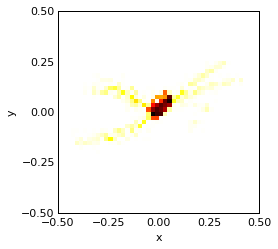

In [145]:
hl.Image(X1[0].squeeze())

Creating the rest
---------------

The rest of the train object stays the same, apart from the save path and that the algorithm will have to load one of these new ParallelDataset objects for its validation set. So, we're missing:

* __algorithm__ - contains validation set, which must be set up as a parallel dataset.
* __extensions__ - keeping these the same but changing save paths

It's worth noting that when we define the cost and the weight decay we have to address the new convolutional layers inside the composite layer.

In [146]:
import pylearn2.training_algorithms.sgd
import pylearn2.costs.mlp.dropout
import pylearn2.costs.cost
import pylearn2.termination_criteria

In [147]:
algorithm = pylearn2.training_algorithms.sgd.SGD(
        train_iteration_mode='even_shuffled_sequential',
        monitor_iteration_mode='even_sequential',
        batch_size=128,
        learning_rate=0.1,
        learning_rule= pylearn2.training_algorithms.learning_rule.Momentum(
            init_momentum=0.5
        ),
        monitoring_dataset={
            'train':dataset,
            'valid':PassthroughDataset(
                transformer=neukrill_net.augment.RandomAugment(
                    units='float',
                    rotate=[0,90,180,270],
                    rotate_is_resizable=0,
                    flip=1,
                    resize=final_shape,
                    normalise={'global_or_pixel':'global',
                               'mu': 0.957,
                               'sigma': 0.142}
                ),
                settings_path=os.path.abspath("settings.json"),
                run_settings_path=os.path.abspath("run_settings/replicate_8aug.json"),
                force=True, training_set_mode='validation'
            )
        },
        cost=pylearn2.costs.cost.SumOfCosts(
            costs=[
                pylearn2.costs.mlp.dropout.Dropout(
                    input_include_probs={'h5':0.5},
                    input_scales={'h5':2.0}),
                pylearn2.costs.mlp.WeightDecay(coeffs={'parallel_conv':0.00005,
                                                'h5':0.00005})
            ]
        ),
        termination_criterion=pylearn2.termination_criteria.EpochCounter(max_epochs=500)
    )

In [148]:
import pylearn2.train_extensions
import pylearn2.train_extensions.best_params

In [149]:
extensions = [
    pylearn2.training_algorithms.learning_rule.MomentumAdjustor(
        start=1,
        saturate=200,
        final_momentum=0.95
    ),
    pylearn2.training_algorithms.sgd.LinearDecayOverEpoch(
        start=1,
        saturate=200,
        decay_factor=0.025
    ),
    pylearn2.train_extensions.best_params.MonitorBasedSaveBest(
        channel_name='valid_y_nll',
        save_path='/disk/scratch/neuroglycerin/models/parallel_interactive_opencv.pkl'
    ),
    pylearn2.training_algorithms.sgd.MonitorBasedLRAdjuster(
        high_trigger=1.0,
        low_trigger=0.999,
        grow_amt=1.012,
        shrink_amt=0.986,
        max_lr=0.4,
        min_lr=0.00005,
        channel_name='valid_y_nll'
    )
]

Assembling the full train object
===========

We now have everything we need to make up our train object, so we can put it together and see how well it runs.

In [150]:
import pylearn2.train

In [151]:
train = pylearn2.train.Train(
    dataset=dataset,
    model=main_mlp,
    algorithm=algorithm,
    extensions=extensions,
    save_path='/disk/scratch/neuroglycerin/models/parallel_interactive_opencv_recent.pkl',
    save_freq=1
)

We can live with that warning. 

Now, attempting to run the model:

In [152]:
train.main_loop()

Parameter and initial learning rate summary:
	h1p5_W: 0.0250000003725
	h1p5_b: 0.0250000003725
	h1_W: 0.10000000149
	h1_b: 0.10000000149
	h2_W: 0.10000000149
	h2_b: 0.10000000149
	h3_W: 0.10000000149
	h3_b: 0.10000000149
	h4_W: 0.10000000149
	h4_b: 0.10000000149
	h5_W: 0.0250000003725
	h5_b: 0.0250000003725
	softmax_b: 0.0250000003725
	softmax_W: 0.0250000003725
Compiling sgd_update...
Compiling sgd_update done. Time elapsed: 6.494259 seconds
compiling begin_record_entry...
compiling begin_record_entry done. Time elapsed: 1.324182 seconds
Monitored channels: 
	learning_rate
	momentum
	total_seconds_last_epoch
	train_h5_col_norms_max
	train_h5_col_norms_mean
	train_h5_col_norms_min
	train_h5_max_x_max_u
	train_h5_max_x_mean_u
	train_h5_max_x_min_u
	train_h5_mean_x_max_u
	train_h5_mean_x_mean_u
	train_h5_mean_x_min_u
	train_h5_min_x_max_u
	train_h5_min_x_mean_u
	train_h5_min_x_min_u
	train_h5_range_x_max_u
	train_h5_range_x_mean_u
	train_h5_range_x_min_u
	train_h5_row_norms_max
	train_h5

ERROR (theano.gof.opt): SeqOptimizer apply MergeOptimizer
ERROR:theano.gof.opt:SeqOptimizer apply MergeOptimizer
ERROR (theano.gof.opt): Traceback:
ERROR:theano.gof.opt:Traceback:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/afs/inf.ed.ac.uk/user/s08/s0805516/repos/Theano/theano/gof/opt.py", line 195, in apply
    sub_prof = optimizer.optimize(fgraph)
  File "/afs/inf.ed.ac.uk/user/s08/s0805516/repos/Theano/theano/gof/opt.py", line 81, in optimize
    ret = self.apply(fgraph, *args, **kwargs)
  File "/afs/inf.ed.ac.uk/user/s08/s0805516/repos/Theano/theano/gof/opt.py", line 621, in apply
    fgraph.replace_all_validate(pairs, 'MergeOptimizer')
  File "/afs/inf.ed.ac.uk/user/s08/s0805516/repos/Theano/theano/gof/toolbox.py", line 258, in replace_all_validate
    fgraph.replace(r, new_r, reason=reason, verbose=False)
  File "/afs/inf.ed.ac.uk/user/s08/s0805516/repos/Theano/theano/gof/fg.py", line 467, in replace
    raise TypeError("The type of the replacement must b

graph size: 717
graph size: 713
Compiling accum done. Time elapsed: 36.505606 seconds
Monitoring step:
	Epochs seen: 0
	Batches seen: 0
	Examples seen: 0
	learning_rate: 0.100000113249
	momentum: 0.49999922514
	total_seconds_last_epoch: 0.0
	train_h5_col_norms_max: 1.09158229828
	train_h5_col_norms_mean: 0.97610026598
	train_h5_col_norms_min: 0.865485668182
	train_h5_max_x_max_u: 0.0374856851995
	train_h5_max_x_mean_u: 0.00641988078132
	train_h5_max_x_min_u: 0.0
	train_h5_mean_x_max_u: 0.0240020323545
	train_h5_mean_x_mean_u: 0.0028201371897
	train_h5_mean_x_min_u: 0.0
	train_h5_min_x_max_u: 0.0103577403352
	train_h5_min_x_mean_u: 0.000680151977576
	train_h5_min_x_min_u: 0.0
	train_h5_range_x_max_u: 0.027447886765
	train_h5_range_x_mean_u: 0.00573972798884
	train_h5_range_x_min_u: 0.0
	train_h5_row_norms_max: 1.69188833237
	train_h5_row_norms_mean: 1.59457719326
	train_h5_row_norms_min: 1.4787914753
	train_objective: 4.84974098206
	train_parallel_conv_convlayer_h1_kernel_norms_max: 0.1

/afs/inf.ed.ac.uk/user/s08/s0805516/repos/pylearn2/pylearn2/monitor.py:573: UserWarning: Trained model saved without indicating yaml_src
  'indicating yaml_src')


Time this epoch: 0:01:44.927378
Monitoring step:
	Epochs seen: 1
	Batches seen: 189
	Examples seen: 24192
	learning_rate: 0.0995122715831
	momentum: 0.49999922514
	total_seconds_last_epoch: 0.0
	train_h5_col_norms_max: 1.08959054947
	train_h5_col_norms_mean: 0.97529989481
	train_h5_col_norms_min: 0.86380147934
	train_h5_max_x_max_u: 1.23018538952
	train_h5_max_x_mean_u: 0.208481952548
	train_h5_max_x_min_u: 0.0
	train_h5_mean_x_max_u: 0.752106904984
	train_h5_mean_x_mean_u: 0.0871087238193
	train_h5_mean_x_min_u: 0.0
	train_h5_min_x_max_u: 0.398169904947
	train_h5_min_x_mean_u: 0.017019148916
	train_h5_min_x_min_u: 0.0
	train_h5_range_x_max_u: 1.08478045464
	train_h5_range_x_mean_u: 0.191462770104
	train_h5_range_x_min_u: 0.0
	train_h5_row_norms_max: 1.69026648998
	train_h5_row_norms_mean: 1.59327042103
	train_h5_row_norms_min: 1.4773734808
	train_objective: 3.97384262085
	train_parallel_conv_convlayer_h1_kernel_norms_max: 0.333131581545
	train_parallel_conv_convlayer_h1_kernel_norms_m

KeyboardInterrupt: 

In [153]:
import pickle

In [154]:
with open('/disk/scratch/s1145806/cached_hlf_train_data.pkl','rb') as f:
    cached = pickle.load(f)

In [155]:
cached.shape

AttributeError: 'NDArrayWrapper' object has no attribute 'shape'

In [157]:
cached = np.load('/disk/scratch/s1145806/cached_hlf_train_data.pkl')

In [158]:
cached.shape

AttributeError: 'NDArrayWrapper' object has no attribute 'shape'

In [156]:
cached

In [161]:
import sklearn.externals.joblib

In [163]:
cached=sklearn.externals.joblib.load('/disk/scratch/s1145806/cached_hlf_train_data.pkl')

In [164]:
cached.shape

(1, 30336, 170)

In [165]:
cached.squeeze().shape

(30336, 170)